In [1]:
#************************************************************************************
# Rezwan Matin
# Thesis B
# Filename: ML_Project_Final_8.py
# Date: 12/11/19
#
# Objective:
# 26 MFCCs (mean) and 26 MFCCs (standard deviation), ZCR.
#
#*************************************************************************************

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa as rosa
import glob
import os
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
# Save directory path in 'path'
path = r'C:/Books/Texas State Books/Fall 2019/Thesis A/Corpus/Simulated/RAVDESS/All'

# Declare a dummy Numpy array (row vector)
result_array = np.empty([1,54])

# Create a list of audio file names 'file_list'
file_list = os.listdir(path)

i=0

for filename in file_list:
    
    # Read WAV file. 'rosa.core.load' returns sampling frequency in 'fs' and audio signal in 'sig'
    sig, fs = rosa.core.load(path + '/' + file_list[i], sr=None)
    
    # 'rosa.feature.mfcc' extracts n_mfccs from signal and stores it into 'mfcc_feat'
    mfcc_feat = rosa.feature.mfcc(y=sig, sr=fs, n_mfcc=26)
    
    # Calculate the average mfcc (utterance-level features) using 'rosa.feat.mfcc()' and 'np.mean' method. '.T' transposes the rows and columns. 'axis=0' indicates average is calculated column-wise
    avg_mfcc_feat = np.mean(rosa.feature.mfcc(y=sig, sr=fs, n_mfcc=26).T,axis=0)
    
    # Calculate the standard deviation of mfcc (utterance-level features) using 'rosa.feat.mfcc()' and 'np.std' method. '.T' transposes the rows and columns. 'axis=0' indicates average is calculated column-wise
    std_mfcc_feat = np.std(rosa.feature.mfcc(y=sig, sr=fs, n_mfcc=26).T,axis=0)
    
    # Calculate the average zero crossing rate (utterance-level feature) using 'rosa.feat.zero_crossing_rate()' and 'np.mean' method. '.T' transposes the rows and columns. 'axis=0' indicates average is calculated column-wise
    zcross_feat = rosa.feature.zero_crossing_rate(sig)
    avg_zcross_feat = np.mean(rosa.feature.zero_crossing_rate(y=sig).T,axis=0)
    
    # Append the three 1D arrays into a single 1D array called 'feat'.
    feat0 = np.append(avg_mfcc_feat, std_mfcc_feat, axis=0)
    
    feat1 = np.append(feat0, avg_zcross_feat, axis=0)
    
    # Save emotion label from file name. 'path' contains directory's address, 'file_list' contains file name, and '\\' joins the two to form file's address
    label = os.path.splitext(os.path.basename(path + '/' + file_list[i]))[0].split('-')[2]
    
    # Create a new Numpy array 'sample' to store features along with label
    sample = np.insert(feat1, obj=53, values=label)
    
    result_array = np.append(result_array, sample)
    
    i+=1

# Print out the 1D Numpy array
result_array

array([1.48219694e-322, 9.11257444e-316, 1.38338381e-322, ...,
       9.32265673e+000, 9.21448291e-002, 8.00000000e+000])

In [3]:
result_array.shape

(77814,)

In [4]:
# Convert 1D Numpy array to 2D array. Argument must be a Tuple. i+1 because we have i samples (audio files) plus a dummy row.
result_array = np.reshape(result_array, (i+1,-1))

# Delete first dummy row from 2D array
result_array = np.delete(result_array, 0, 0)

# Print final 2D Numpy array 
result_array.shape

(1440, 54)

In [5]:
df = pd.DataFrame(data=result_array)
# Label only the last (target) column
df = df.rename({53: "Emotion"}, axis='columns')
# Delete unnecessary emotion data (calm)
df.drop(df[df['Emotion'] == 2.0].index, inplace = True)
df['Emotion'].replace({1.0: "Neutral", 3.0: "Happy", 4.0: "Sad", 5.0: "Angry", 6.0: "Fearful", 7.0: "Disgust", 8.0: "Surprised"}, inplace=True)
# Reset row (sample) indexing
df = df.reset_index(drop=True)
df.head(12)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,Emotion
0,-726.217274,68.541416,3.293398,12.205299,5.510278,13.667407,-2.983828,3.098029,-3.310813,-1.564385,...,5.425878,5.689251,7.162549,4.863709,5.585770,3.488844,5.367161,6.340625,0.050476,Neutral
1,-675.851962,68.959275,-4.962724,5.423068,0.609827,3.160781,-9.528728,2.647623,-9.230346,-3.492293,...,7.914243,5.654738,7.926573,7.294551,8.209560,7.293256,7.341540,6.102733,0.055098,Neutral
2,-650.819464,75.059091,-1.558455,10.676362,3.448231,9.053379,-3.507790,-5.246797,-8.943635,-2.100304,...,5.704100,6.260803,5.771089,7.325422,4.801887,6.249477,5.842002,5.776897,0.057811,Neutral
3,-718.598668,60.431713,-7.502653,8.470610,0.099280,2.274320,-9.095821,1.328662,-10.593964,-6.960267,...,6.607022,5.706694,4.840397,6.876870,10.203698,11.689911,8.299857,7.492363,0.049154,Neutral
4,-745.625665,79.437893,11.096364,14.473478,7.888486,15.526609,-2.419525,4.976626,-0.916208,-1.138914,...,4.392219,5.691560,7.304565,4.541160,5.775279,4.684903,4.733820,3.938220,0.061711,Neutral
5,-767.462590,73.540088,-14.753669,3.762173,2.184717,7.149111,-11.638861,-3.927076,-6.337936,-7.772809,...,8.688997,6.170362,8.317585,6.077283,7.317003,8.120423,5.786133,4.823799,0.063484,Neutral
6,-685.116600,91.437208,6.689504,19.391893,8.057633,17.248403,-7.020537,2.327569,-8.877209,-1.717042,...,6.270341,8.089153,5.502664,5.059152,5.574554,4.185490,5.535855,6.260219,0.073121,Neutral
7,-724.681549,78.935860,8.528006,21.338789,9.212904,15.382850,-6.691698,14.009060,-6.308382,-2.718124,...,6.895123,7.899635,6.076923,7.249549,7.542714,5.686461,6.341204,6.306932,0.058015,Neutral
8,-772.303192,100.141233,22.751473,28.350563,20.882337,24.289950,5.614293,8.056147,4.342381,4.477574,...,6.952332,6.956904,4.917133,6.264295,6.726540,6.639472,4.482355,5.056610,0.033976,Neutral
9,-596.937839,64.640544,6.658105,8.087178,-0.222232,11.440669,-8.109157,0.893834,-8.189038,-3.269589,...,8.566395,7.195438,8.436254,9.116186,6.072399,7.030783,10.201778,5.616832,0.097845,Neutral


In [6]:
df['Emotion'].value_counts()

Angry        192
Happy        192
Disgust      192
Surprised    192
Fearful      192
Sad          192
Neutral       96
Name: Emotion, dtype: int64

In [7]:
# Balance the dataset for equal number of samples for each class.
# Separate majority and minority classes
df_minority = df[df.Emotion=="Neutral"]
df_majority3 = df[df.Emotion=="Happy"]
df_majority4 = df[df.Emotion=="Sad"]
df_majority5 = df[df.Emotion=="Angry"]
df_majority6 = df[df.Emotion=="Fearful"]
df_majority7 = df[df.Emotion=="Disgust"]
df_majority8 = df[df.Emotion=="Surprised"]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=192,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority3, df_majority4, df_majority5, df_majority6, df_majority7, df_majority8])
 
# Display new class counts
df_upsampled.Emotion.value_counts()

# Reset row (sample) indexing
df_upsampled = df_upsampled.reset_index(drop=True)

df_upsampled['Emotion'].value_counts()

Angry        192
Happy        192
Neutral      192
Fearful      192
Disgust      192
Surprised    192
Sad          192
Name: Emotion, dtype: int64

In [8]:
# Extract target feature 'Emotion' in a vector y. Indexing from 0
y = df_upsampled.iloc[0:1344, 53].values
# Extract features 'buying' and 'safety' in a vector X. Indexing from 0
X = df_upsampled.iloc[0:1344, list(range(53))].values
print(y)

['Neutral' 'Neutral' 'Neutral' ... 'Surprised' 'Surprised' 'Surprised']


In [9]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

# Create an object 'sc'
sc = StandardScaler()

# Scale training data
sc.fit(X_train)
X_train_std = sc.transform(X_train)

In [10]:
# Create SVM model with hyperparameters
#svm = SVC(kernel='sigmoid', C=10.0, random_state=1)

# Best settings from GridSearchCV
svm = SVC(kernel='rbf', C=6.0, gamma=0.028, random_state=1)

# This is training the model
svm.fit(X_train_std, y_train)

SVC(C=6.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.028, kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [11]:
# Scale test data
sc.fit(X_test)
X_test_std = sc.transform(X_test)

# Test the model data
y_pred = svm.predict(X_test_std)

In [12]:
# Print out the performance metrics
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Training Accuracy: %.2f' % svm.score(X_train_std, y_train))
#print('Test Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('Test Accuracy: %.2f' % svm.score(X_test_std, y_test))

# Print out the performance metrics in a text file.
#text_file = open("Emotion Classifier Performance Metrics.txt", "w")
#text_file.write('Misclassified samples: %d' % (y_test != y_pred).sum())
#text_file.write('Training Accuracy: %.2f' % svm.score(X_train_std, y_train))
#text_file.write('Test Accuracy: %.2f' % svm.score(X_test_std, y_test))
#text_file.close()

Misclassified samples: 56
Training Accuracy: 1.00
Test Accuracy: 0.83


In [87]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

# This is the setup, nothing gets executed yet…
#pipe_svc = make_pipeline(StandardScaler(), PCA(n_components=2), SVC(random_state=1))

# Create an object 'sc'
sc = StandardScaler()

# Scale training data
sc.fit(X_train)
X_train_std = sc.transform(X_train)

# Scale test data
sc.fit(X_test)
X_test_std = sc.transform(X_test)

pipe_svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=5.5, gamma=0.03, random_state=1))

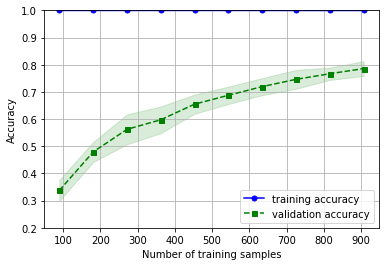

In [84]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svc, X=X_train_std, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig = plt.figure()
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.2, 1.0])
plt.show()

# Save plot as PNG file
fig.savefig('Learning curve no noise.png')

In [88]:
pipe_svc.fit(X_train_std, y_train)
y_pred = pipe_svc.predict(X_test_std)
#class_names = df_upsampled['Emotion'].unique()
class_names = np.unique(y_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=class_names)
print(confmat)
confmat.shape
pd.DataFrame(confmat, index=class_names, columns=class_names)

[[38  3  0  5  0  0  2]
 [ 1 43  0  2  2  0  0]
 [ 2  1 38  1  2  4  0]
 [ 4  1  2 37  0  3  1]
 [ 0  0  0  0 47  0  1]
 [ 0  1  6  0  1 38  2]
 [ 1  0  5  1  0  2 39]]


,Angry,Disgust,Fearful,Happy,Neutral,Sad,Surprised
Angry,38,3,0,5,0,0,2
Disgust,1,43,0,2,2,0,0
Fearful,2,1,38,1,2,4,0
Happy,4,1,2,37,0,3,1
Neutral,0,0,0,0,47,0,1
Sad,0,1,6,0,1,38,2
Surprised,1,0,5,1,0,2,39


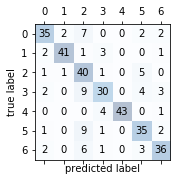

In [22]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()
fig.savefig('Confusion matrix no noise.png')

Confusion matrix, without normalization
[[38  3  0  5  0  0  2]
 [ 1 43  0  2  2  0  0]
 [ 2  1 38  1  2  4  0]
 [ 4  1  2 37  0  3  1]
 [ 0  0  0  0 47  0  1]
 [ 0  1  6  0  1 38  2]
 [ 1  0  5  1  0  2 39]]


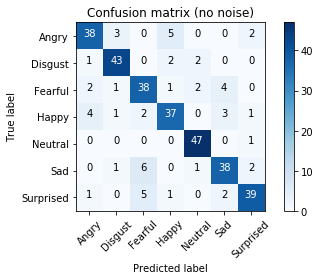

In [89]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(confmat, class_names, title='Confusion matrix (no noise)')
plt.show()

In [38]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45, test_size=0.05)
    

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear')
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

ImportError: cannot import name '_chunk_generator' from 'sklearn.utils' (C:\Users\Maleeha\Anaconda3\lib\site-packages\sklearn\utils\__init__.py)

In [48]:
df_upsampled['Emotion'].get_value()

TypeError: get_value() missing 1 required positional argument: 'label'

In [62]:
set(y_test)

{'Angry', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised'}

In [6]:
b = '1001'
len(b)

4

In [4]:
for i in b:
    print(i)

1
0
0
1


In [7]:
check = isinstance(5, int)
check

True

In [11]:
101001
a = bin(41)[2:].strip('0').strip('1').split('1')
a

['0', '00']

In [13]:
b = [1,2,3]
len(b)

3

NameError: name 'ones' is not defined

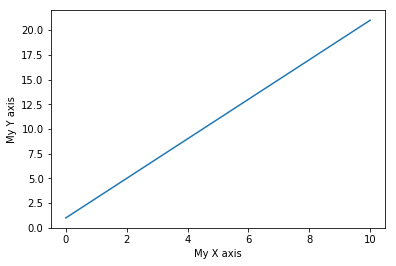

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define an object 'fig'. The method 'figure()' generate a figure.
fig = plt.figure()

# Use Numpy's 'linspace()' method to produce 10 values in the range 0 to 10.
x = np.linspace(0, 10, 10)
# Define a straight-line equation for y.
y = 2*x + 1

# This creates the plot.
plt.plot(x,y)
# Label the axes.
plt.xlabel('My X axis')
plt.ylabel('My Y axis')

# To show plot in Jupyter Notebook.
plt.show()

# Save plot as PNG file.
fig.savefig('Straight Line Plot.png')

In [1]:
# scanf in Python
i = 4
while i < 5:
    a = input("Please enter a positive integer ")
    a = int(a)
    if a<=0:
        print("Try again!")
    else:
        print(a)
        break

Please enter a positive integer -1
Try again!
Please enter a positive integer 0
Try again!
Please enter a positive integer 3
3


In [9]:
# Square numbers in a list
r = [1,2,3]
l = [0]*3
for i in range(0,3):
    l[i] = r[i]*r[i]
print(l)

[1, 4, 9]
